# Определение перспективного тарифа для телеком компании

## 1. Обзор данных и предобработка

**Библиотеки**

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

**Таблицы**

In [2]:
data_calls = pd.read_csv('calls.csv')
data_internet = pd.read_csv('internet.csv')
data_messages = pd.read_csv('messages.csv')
data_tariffs = pd.read_csv('tariffs.csv')
data_users = pd.read_csv('users.csv')

### Информация о звонках

In [3]:
data_calls.head(5)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [5]:
data_calls.duplicated().sum()

0

На всякий случай отдельно посмотрим на столбец duration на предмет аномалий

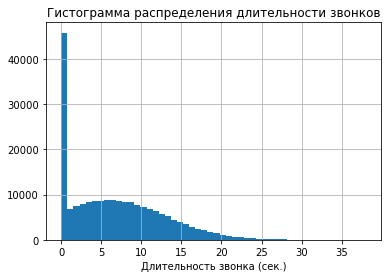

In [6]:
data_calls['duration'].hist(bins=50)
plt.title('Гистограмма распределения длительности звонков')
plt.xlabel('Длительность звонка (сек.)');

**Что исправить**
1. Нужно привести дату к типу datetime, чтобы с ней было удобно работать
2. Длительность всех звонков надо округлить в большую сторону до целого числа. Оператор всегда округляет их до минуты, даже если звонок длится 1 секнуду. После округления можно перевести весь столбец в int.

Кроме того, на гистограмме мы видим очень много звонков с нулевой продолжительностью. В описании проекта было сказано, что это не ошибка, а просто пропущенные звонки и удалять их не нужно. 

In [7]:
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y-%m-%d')

In [8]:
data_calls['duration'] = data_calls['duration'].apply(math.ceil)
data_calls['duration'] = data_calls['duration'].astype('int')

### Информация об интернет-сессиях

In [9]:
data_internet.head(5)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [10]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [11]:
print('Количество дубликатов =', data_internet.duplicated().sum())

Количество дубликатов = 0


Снова на всякий случай отдельно посмотрим на столбец mb_used на предмет ошибок

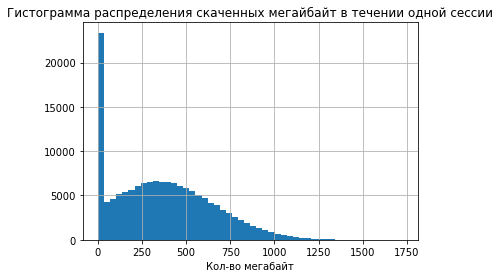

In [12]:
data_internet['mb_used'].hist(bins=50)
plt.title('Гистограмма распределения скаченных мегайбайт в течении одной сессии')
plt.xlabel('Кол-во мегабайт');

Снова есть нулевые значения. Возможно, это сессии, которые начались и тут же закончились: устройство не успело принять или передать данные. Округлять траффик сейчас не будем, потому что по правилу оператора, это делается не с отдельными сессиями, а по итогам месяца. 

**Что исправить**
1. Нужно перевести столбец с датой в дейттайм
2. В таблице есть столбец "Unnamed:0", который, судя по всему, просто повторяет индексацию каждой строки. Нам он для дальнейше работы не нужен.

In [13]:
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d')

In [14]:
data_internet = data_internet[['id','mb_used','session_date', 'user_id']]

### Информация о сообщениях

In [15]:
data_messages.sample(5)

,id,message_date,user_id
116243,1472_547,2018-08-17,1472
106531,1431_273,2018-05-05,1431
119762,1484_283,2018-09-07,1484
15475,1066_217,2018-06-29,1066
13227,1055_193,2018-12-04,1055


In [16]:
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [17]:
print('Количество дубликатов =', data_messages.duplicated().sum())

Количество дубликатов = 0


**Что исправить**
1. Нужно изменить тип столбца с датой в дейттайм

In [18]:
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d')

### Информация о пользователях

In [19]:
data_users.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [20]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [21]:
print('Количество дубликатов =', data_users.duplicated().sum())

Количество дубликатов = 0


**Что сделать**
1. Столбец reg_date - перевести в дейттайм
2. Столбец churn_date - перевести в дейттайм
3. Проверить названия городов, чтобы не было дублей, и мы могли группировать по ним
4. Проверить написание наваний тарифов
5. На всякий случай посмотрим еще и возраст

In [22]:
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format='%Y-%m-%d')

In [23]:
data_users['churn_date'] = pd.to_datetime(data_users['churn_date'], format='%Y-%m-%d')

In [24]:
data_users['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

In [25]:
data_users['tariff'].unique()

array(['ultra', 'smart'], dtype=object)

In [26]:
data_users['age'].describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

С названиями все ок. Возраст тоже в норме. 

### Информация о тарифах

In [27]:
data_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [28]:
data_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Здесь все ок - маленькая табличка с нужными параметрами тарифов

## 3. Добавляем расчеты

Задача этапа - посчитать для каждого пользователя: 
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

### Звонки
Добавляем количество сделанных звонков и израсходованных минут разговора по месяцам.

Чтобы агрегировать по месяцам, нужно добавить отдельный столбец с месяцем звонка

In [29]:
data_calls['month'] = data_calls['call_date'].dt.month

In [30]:
data_calls_pivot = data_calls.pivot_table(index=['user_id','month'], 
                       values=['duration', 'id'], 
                       aggfunc={'duration' : 'sum', 
                                'id' : 'count'})
data_calls_pivot.columns = ['min_used', 'calls_count']

### Сообщения
Добавляем количество отправленных сообщений по месяцам.

Аналогично - сначала надо добавить месяц

In [31]:
data_messages['month'] = data_messages['message_date'].dt.month

In [32]:
data_messages_pivot = data_messages.pivot_table(index=['user_id','month'], 
                       values='id', 
                       aggfunc='count')
data_messages_pivot.columns = ['message_count']

### Интернет
Добавляем объем израсходованного интернет-трафика по месяцам.

И снова сначала добавим месяц

In [33]:
data_internet['month'] = data_internet['session_date'].dt.month

In [34]:
data_internet_pivot = data_internet.pivot_table(index=['user_id','month'], 
                       values='mb_used', 
                       aggfunc='sum')

Для дальнейших расчетов надо сразу окргулить траффик за месяц до целых гигабайтов. Сделаем простую функцию: она берет целую часть от деления на 1024, и если остаток не нулевой, прибавляет к результату еще 1. 

In [35]:
def traffic_converter(mb):
    gb = mb // 1024
    if mb % 1024 > 0:
        gb += 1
    return gb

Применим функцию ко всем значениям и переведем их в гигабайты

In [36]:
data_internet_pivot['mb_used'] = data_internet_pivot['mb_used'].apply(traffic_converter)

Сразу переименуем столбец и переведем его в int

In [37]:
data_internet_pivot.columns = ['gb_used']
data_internet_pivot['gb_used'] = data_internet_pivot['gb_used'].astype('int')

### Выручка
Нужно посчитать помесячную выручку с каждого пользователя: 
1. Вычесть бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; 
2. Умножить остаток на значение из тарифного плана; 
3. Прибавить абонентскую плату, соответствующую тарифному плану.

Для начала нужно склеить все сводные таблички в одну

In [38]:
user_stat = data_calls_pivot.join(data_internet_pivot, how='outer').join(data_messages_pivot, how='outer')

1. Заполним все значения NaN нулями. Если их нет, значит в этом месяце пользователь просто не использовал услугу. 
2. Гигабайты и сообщения переведем в int. 
3. Переименуем столбцы для простоты

In [39]:
user_stat = user_stat.fillna(0)
user_stat['gb_used'] = user_stat['gb_used'].astype('int')
user_stat['message_count'] = user_stat['message_count'].astype('int')
user_stat.columns = ['mins', 'calls', 'gb', 'messages']

Теперь добавляем для каждого пользователя его тариф из таблички пользователей. 

In [40]:
user_stat = user_stat.join(data_users.set_index('user_id')[['tariff', 'city']])

Для удобства дальнейшего обращения в функции при подсчете, сделаем названия тарифов индексами в табличке с параметрами тарифов. 

In [41]:
data_tariffs.set_index('tariff_name', inplace=True)

Теперь напишем функцию, которая будет подсчитывать выручку с каждого абонента по тарифу. Точнее, функции будет две. 
1. Первая считает выручку по конкретному тарифу, получая названия тарифа, количество минут, гигов и сообщений.
2. Вторая - та, что будет применяться к каждой строчке. Она достает нужные значения из строки, передает их первой функции и возвращает результат. 

In [42]:
#первая функция
def proceeds_counter(tariff_name, messages, gb, mins):
    proceeds = data_tariffs.loc[tariff_name, 'rub_monthly_fee']
    messages_diff = messages - data_tariffs.loc[tariff_name, 'messages_included']
    mins_diff = mins - data_tariffs.loc[tariff_name, 'minutes_included']
    internet_diff = gb - data_tariffs.loc[tariff_name, 'mb_per_month_included'] / 1024
    if  messages_diff > 0:
        proceeds += messages_diff * data_tariffs.loc[tariff_name, 'rub_per_message']
    if mins_diff > 0:
        proceeds += mins_diff * data_tariffs.loc[tariff_name, 'rub_per_minute']
    if internet_diff > 0:
        proceeds += internet_diff * data_tariffs.loc[tariff_name, 'rub_per_gb']
    return proceeds

#вторая функция
def tariff_proceeds(row):
    tariff_name = row['tariff']
    messages = row['messages']
    gb = row['gb']
    mins = row['mins']
    return proceeds_counter(tariff_name, messages, gb, mins) 

Теперь применим вторую функцию к каждой строчке и создадим новый столбец с выручкой по каждому пользователю по каждому месяцу.

In [43]:
user_stat['proceeds'] = user_stat.apply(tariff_proceeds, axis=1)

In [44]:
user_stat

mins  calls  gb  messages tariff         city  proceeds
user_id month                                                          
1000    5      159.0   22.0   3        22  ultra    Краснодар    1950.0
        6      172.0   43.0  23        60  ultra    Краснодар    1950.0
        7      340.0   47.0  14        75  ultra    Краснодар    1950.0
        8      408.0   52.0  14        81  ultra    Краснодар    1950.0
        9      466.0   58.0  15        57  ultra    Краснодар    1950.0
...              ...    ...  ..       ...    ...          ...       ...
1498    10     247.0   41.0  21        42  smart  Владикавказ    1750.0
1499    9       70.0    9.0   2        11  smart        Пермь     550.0
        10     449.0   68.0  18        48  smart        Пермь    1150.0
        11     612.0   74.0  18        59  smart        Пермь    1513.0
        12     492.0   69.0  13        66  smart        Пермь     598.0

[3214 rows x 7 columns]

Таблица для проверки гипотез на шаге №4 - готова

## 4. Анализ данных

Задача этапа: описать поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 
- Посчитать среднее количество, дисперсию и стандартное отклонение. 
- Построить гистограммы. 
- Описать распределения.

Для этого этапа сделаем копию таблички user_stat, чтобы выполнять нужные преобразования и не испорить ее для этапа проверки гипотез. 
- Уберем из нее столбец с выручкой и количеством звонков
- Сбросим двойную индексацию, она больше не нужна

In [45]:
user_stat_df = user_stat[['mins','gb','messages','tariff']]
user_stat_df.reset_index(inplace=True)

In [46]:
user_stat_df

,user_id,month,mins,gb,messages,tariff
0,1000,5,159.0,3,22,ultra
1,1000,6,172.0,23,60,ultra
2,1000,7,340.0,14,75,ultra
3,1000,8,408.0,14,81,ultra
4,1000,9,466.0,15,57,ultra
...,...,...,...,...,...,...
3209,1498,10,247.0,21,42,smart
3210,1499,9,70.0,2,11,smart
3211,1499,10,449.0,18,48,smart
3212,1499,11,612.0,18,59,smart


Напишем функцию, которая будет сразу выводить весь анализ: среднее, дисперсию, стд.отклонение, а еще показывать гистограмму и боксплот. На вход отдаем название тарифа, нужный нам столбец и количество корзин для гистограммы. 

In [47]:
def data_describer(tariff_name, parameter, hist_bins):
    series = user_stat_df.query('tariff == @tariff_name')[parameter]
    
    print('Среднее количество:', round(series.mean(), 2))
    print('Дисперсия:', round(np.var(series, ddof=1), 2))
    print('Стандартное отклонение:', round(np.std(series, ddof=1), 2))
    
    series.hist(bins=hist_bins)
    plt.title("Частотная гистограмма. Тариф: {}".format(tariff_name))
    plt.xlabel(parameter)
    plt.ylabel('частота')
    
    plt.show()
    
    user_stat_df.query('tariff == @tariff_name').boxplot(parameter)
    plt.title("График распределения boxplot. Тариф: {}".format(tariff_name))

### Минуты

#### Тариф "Ультра"

Среднее количество: 526.62
Дисперсия: 100873.63
Стандартное отклонение: 317.61


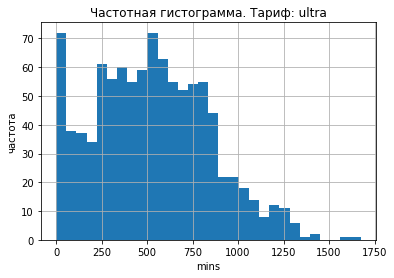

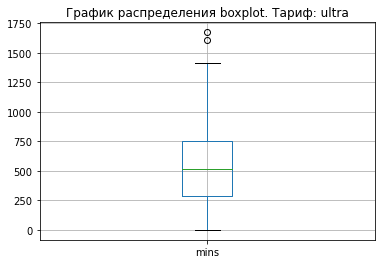

In [48]:
data_describer('ultra', 'mins', 30)

**Минуты. Ультра. Выводы**
- Данные скошены вправо
- В среднем пользователи тарифа тратят всего 526 минут (при имеющихся в пакете 3000!)
- Стандартное отклонение - 317 минут
- Максимальное значение даже близко не подбирается к границе пакета минут
- Пользователи тарифа недоиспользуют его возможности

#### Тариф "Смарт"

Среднее количество: 417.93
Дисперсия: 36219.32
Стандартное отклонение: 190.31


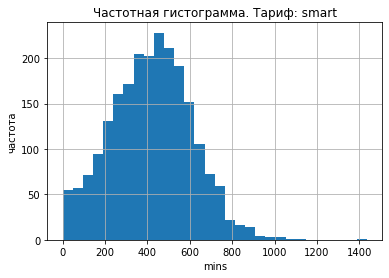

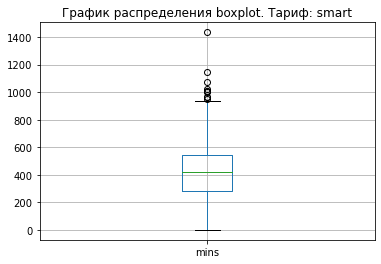

In [49]:
data_describer('smart', 'mins', 30)

**Минуты. Смарт. Выводы**
- Данные распределены нормально
- В среднем пользователи тарифа тратят 418 минут в месяц (500 в пакете)
- Стандартное отклонение - 190 минут
- Справа на гистограмме есть хвост: при всего 500 минутах в пакете, есть и такие пользователи, которые тратят и 1000 и даже 1400 минут

### Гигабайты

#### Тариф "Ультра"

Среднее количество: 19.49
Дисперсия: 97.09
Стандартное отклонение: 9.85


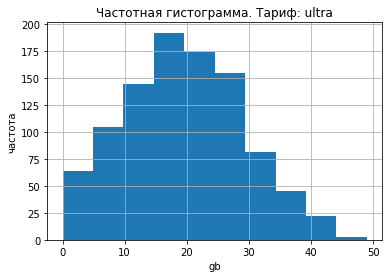

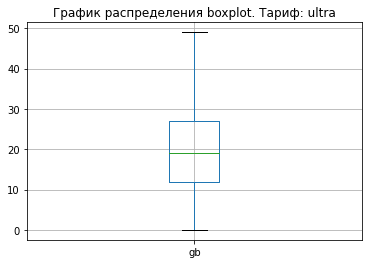

In [50]:
data_describer('ultra', 'gb', 10)

**Гиги. Ультра. Выводы**
- Данные распределены нормально
- В среднем пользователи тарифа тратят 19 гигабайт в месяц (30 в пакете)
- Стандартное отклонение - 10 гигабайт 
- Данные лежат очень плотно, без выборосов: межквартильный размах приходится ровно на весь диапозон данных
- Большая часть пользователей недоиспользует возможности тарифа

#### Тариф "Смарт"

Среднее количество: 16.33
Дисперсия: 33.03
Стандартное отклонение: 5.75


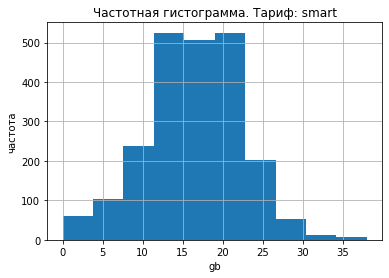

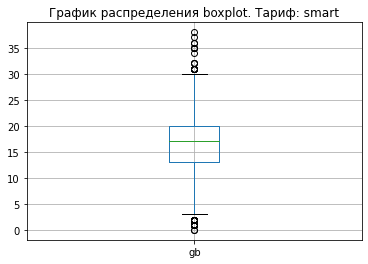

In [51]:
data_describer('smart', 'gb', 10)

**Гиги. Смарт. Выводы**
- Гистограмма похожа на нормальное распределение
- В среднем пользователи тарифа тратят 16 гигабайт в месяц (15 в пакете), и это всего на 3 гига меньше, чем пользователи Ультры
- Особенная "скученность" есть между 13 и 20 гигами (в этом диапозоне больше всего пользователей)
- Стандартное отклонение - 6 гигабайт 

### Минуты

#### Тариф "Ультра"

Среднее количество: 49.36
Дисперсия: 2285.27
Стандартное отклонение: 47.8


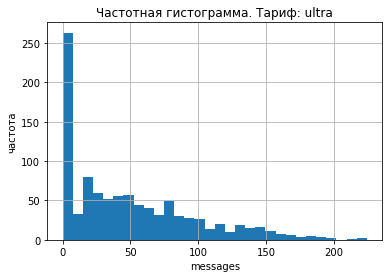

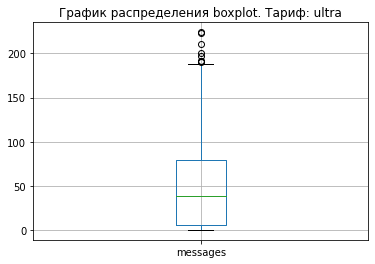

In [52]:
data_describer('ultra', 'messages', 30)

**Сообщения. Ультра. Выводы**
- Огромное количество пользователей не используют смски
- Распределение сложно оценить, потому как данные очень смещены за счет огромной "палки" в самом начале гистограммы

Давайте ради эксперимента уберем пользователей с нулём смсок и оценим распределение среди тех, кто вообще отправляет сообщения. 

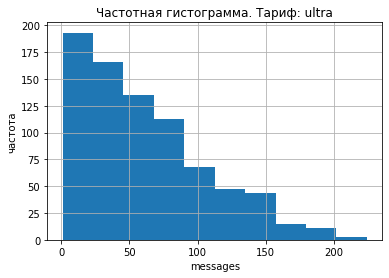

In [53]:
ultra_messages = user_stat_df.query('tariff == "ultra" and messages != 0')['messages']
ultra_messages.hist()
plt.title("Частотная гистограмма. Тариф: ultra")
plt.xlabel('messages')
plt.ylabel('частота');

In [54]:
print('Среднее количество:', round(ultra_messages.mean(),2))
print('Дисперсия:', round(np.var(ultra_messages, ddof=1),2))
print('Стандартное отклонение:', round(np.std(ultra_messages, ddof=1),2))

Среднее количество: 61.16
Дисперсия: 2109.66
Стандартное отклонение: 45.93


**Сообщения. Ультра. Выводы 2**
- Данные скошены вправо
- Среди тех, кто использует смски есть очевидный тренд: чем больше количество смс, тем меньше людей столько отправляет.
- Среднее - 61, а стандартное отклонение - 46
- И снова важное наблюдение: пользователи недоиспользуют тариф; в пакете 1000 сообщений, а мы видим максимум 200

#### Тариф "Смарт"

Среднее количество: 33.38
Дисперсия: 796.81
Стандартное отклонение: 28.23


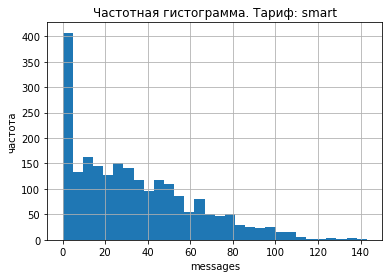

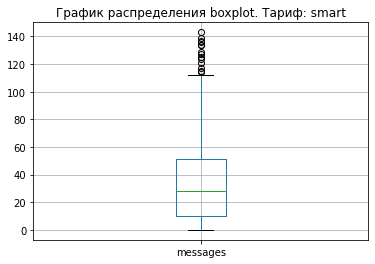

In [55]:
data_describer('smart', 'messages', 30)

**Сообщения. Смарт. Выводы**
- Такая же история: очень много пользователей, которые не отправляют сообщения. 
- Посмотрим на тех, кто все таки это делает. 


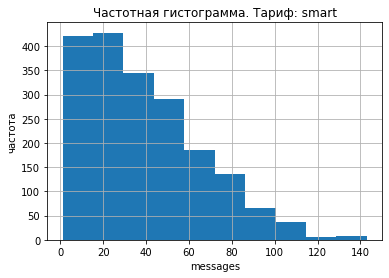

In [56]:
smart_messages = user_stat_df.query('tariff == "smart" and messages != 0')['messages']
smart_messages.hist()
plt.title("Частотная гистограмма. Тариф: smart")
plt.xlabel('messages')
plt.ylabel('частота');

In [57]:
print('Среднее количество:', round(smart_messages.mean(),2))
print('Дисперсия:', round(np.var(smart_messages, ddof=1),2))
print('Стандартное отклонение:', round(np.std(smart_messages, ddof=1),2))

Среднее количество: 38.72
Дисперсия: 717.59
Стандартное отклонение: 26.79


**Сообщения. Смарт. Выводы 2**
- Очень похоже на поведение пользователей ультры
- Данные скошены вправо
- Среди тех, кто использует смски есть очевидный тренд: чем больше количество смс, тем меньше людей столько отправляет.
- Среднее и стд отличаются от ультры где-то в полтора раза: среднее - 39, а стандартное отклонение - 27 (размеры пакетов при этом отличаются в 20 раз)

### Вывод

Исследовали поведение пользователей тарифов Ультра и Смарт. 

В среднем пользователи тарифа Ультра используют в месяц:
- 526 минут
- 19 гигабайт
- 49 сообщений

Аналогично пользователи тарифа Смарт:
- 418 минут
- 16 гигабайт
- 33 сообщения

Можно легко заметить, что значения пользователей Смарта и Ультры отличаются на единицы и десятки, в то время как лимиты по пакетам (и их стоимость) отличаются в разы. 
- Пользователи Ультры в среднем недоиспользуют все возможности тарифа. 
- Пользователи Смарта в среднем укладываются в лимит, но что-то все же приходится докупать

## Проверка гипотез

Задача - проверить гипотезы: 
1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

### Гипотеза 1: выручка Ультры и Смарта

Формулируем нулевую и альтернативную гипотезы. Нулевая должна быть сформулирована со знаком равенства, поэтому:
- H0: Средняя выручка пользователей тарифа "Ультра" равна средней выручке пользователей тарифа "Смарт"
- H1: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Гипотеза двустороняя, сравниваем две генеральные совокупности. Между выборками нет зависимости. Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применяем метод scipy.stats.ttest_**ind**.
Критический уровень статистической значимости возьмем равным 0.05.

In [58]:
alpha = 0.05

In [59]:
#забираем выручку для разных тарифов в разные массивы
proceeds_ultra = user_stat.query('tariff == "ultra"')['proceeds']
proceeds_smart = user_stat.query('tariff == "smart"')['proceeds']

#проводим проверку
results = st.ttest_ind (proceeds_smart, proceeds_ultra)

#сравниваем результаты и делаем вывод
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.4229814360764067e-160
Отвергаем нулевую гипотезу


Посмотрим как отличаются средние выручки по обоим столбцам

In [60]:
print('Средняя выручка пользователей тарифа "Смарт"', round(proceeds_smart.mean()), '₽')
print('Средняя выручка пользователей тарифа "Ультра"', round(proceeds_ultra.mean()), '₽')

Средняя выручка пользователей тарифа "Смарт" 1290 ₽
Средняя выручка пользователей тарифа "Ультра" 2070 ₽


**Вывод**
- Данные не противоречат гипотезе о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
- Этому не противоречат и сами средние значения: средняя выручка по Ультре больше 800 рублей.


### Гипотеза 1: выручка Москвы и регионов

Формулируем нулевую и альтернативную гипотезы. Нулевая должна быть сформулирована со знаком равенства, поэтому:
- H0: Средняя выручка пользователей из Москвы равна средней выручке пользователей регионов
- H1: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Гипотеза двустороняя, сравниваем две генеральные совокупности. Между выборками нет зависимости. Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применяем метод scipy.stats.ttest_**ind**.
Критический уровень статистической значимости возьмем равным 0.05 (мы уже задали его выше).

Сейчас в нашей таблице нет данных о регионе пользователя. Давайте добавим это. 

In [61]:
#забираем выручку для москвы и регионов в разные массивы
proceeds_moscow = user_stat.query('city == "Москва"')['proceeds']
proceeds_other = user_stat.query('city != "Москва"')['proceeds']

#проводим проверку
results = st.ttest_ind (proceeds_moscow, proceeds_other)

#сравниваем результаты и делаем вывод
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


Посмотрим как отличаются средние выручки по обоим столбцам

In [62]:
print('Средняя выручка пользователей из Москвы', round(proceeds_moscow.mean()), '₽')
print('Средняя выручка пользователей из регионов', round(proceeds_other.mean()), '₽')

Средняя выручка пользователей из Москвы 1547 ₽
Средняя выручка пользователей из регионов 1525 ₽


**Вывод**
- Данные не противоречат гипотезе о том, что средняя выручка пользователей из Москвы равна средней выручке пользователей регионов
- Показатели средней выручки так же подтверждают это: 1547 и 1525 - существенно разницы действительно нет


## Вывод

В нашем исследовании мы анализировали поведение клиентов компании Мегалайн и сравнивали тарифы с точки зрениях выручки для оператора. 

**Что выяснили**
1. **Поведение пользователей двух тарифов отличается.**
- В среднем пользователи Смарта используют включенные в пакет тарифа минуты, сообщения и гиги полностью. 
- Пользователи же Ультры обычно не используют весь пакет, причем в случае с минутами и сообщениями - отличие на порядок. 

2. **Проверка гипотез о выручке говорит следующее:**
- Данные не противоречат предположению, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
- При этом, судя по всему, средняя выручка пользователей из Москвы и из других регионов, наоборот, значимо не отличается. Данные говорят о том, что гипотезу о равенстве выручек мы отвергнуть не можем. 

3. **Выяснили - какой тариф лучше**
- Судя по всему - большую выручку приносит тариф "Ультра". 
- Но выручка не показывает маржинальность. Тариф "Ультра" стоит дороже, но и предлагает пользователям больше.
- Гипотетический вывод поможет сделать исследование поведения пользователей. Мы увидели, что пользователи Ультры используют не намного больше минут, гигов и сообщений, чем пользователи Смарта. 
- Получается, что "Мегалайн" тратит схожее количество ресурсов на пользователей Ультры и Смарта, а денег получает больше от Ультры. 
- **Вывод: Тариф "Ультра" - лучше.**